### Importações das Bibliotecas

In [6]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
torch.__version__

'2.3.1+cpu'

#### Seed da Rede Neural

In [2]:
torchSeed = 10
torch.manual_seed(torchSeed)

#### Transform para a base de Treinamento

In [4]:
transformTrain = transforms.Compose(
    [
        transforms.Resize([64, 64]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1, 1.2)),
        transforms.ToTensor()
    ]
)

#### Transform para a base de Teste

In [5]:
transformTest = transforms.Compose(
    [
        transforms.Resize([64, 64]),
        transforms.ToTensor()
    ]
)

In [6]:
dirPathTrain = r"C:\Users\terce\Documents\IC - Ultrasom\code\data\train"
trainDataset = datasets.ImageFolder(dirPathTrain , transform=transformTrain)
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=32, shuffle=True)
trainDataset.classes

['normal', 'tumor']

In [7]:
dirPathTest = r"C:\Users\terce\Documents\IC - Ultrasom\code\data\test"
testDataset = datasets.ImageFolder(dirPathTest, transform=transformTest)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=32, shuffle=False)
testDataset.classes

['normal', 'tumor']

### Testando as Imagens

In [9]:
classNames  = ['normal', 'tumor']
def seeImage(dataset, isTensor):
    fig = plt.figure(figsize=(8,8))
    rows, cols = 2, 2
    for i in range(1,5):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        fig.add_subplot(rows, cols, i)
        plt.title(classNames[label])
        plt.axis("off")
        if isTensor:
            plt.imshow(img.squeeze().permute(1,2,0))
        else:
            plt.imshow(img)

    plt.show()

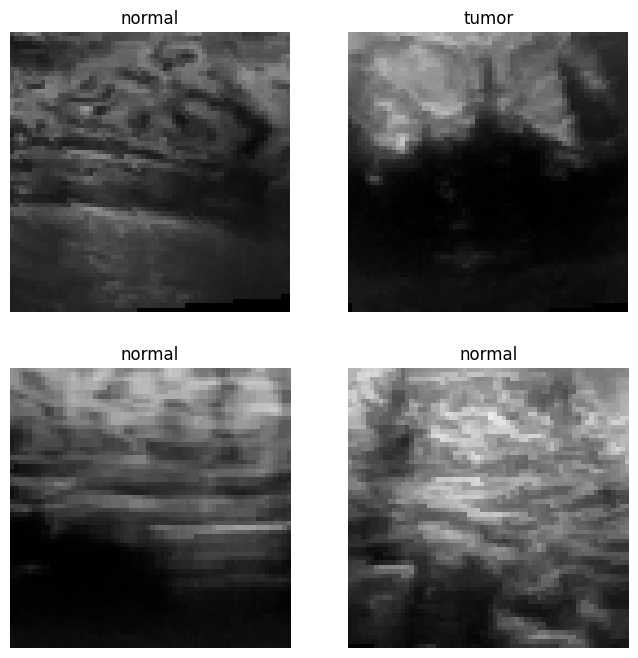

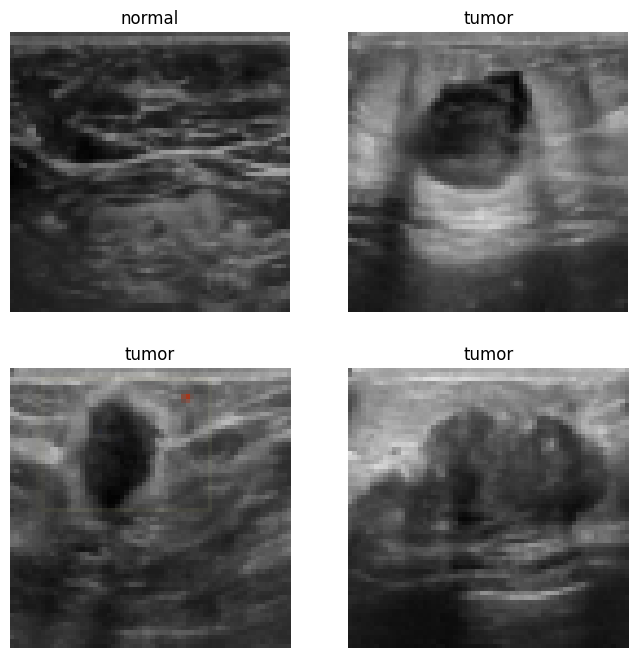

In [20]:
seeImage(trainDataset, True)
seeImage(testDataset, True)

In [10]:
device = torch.device('cpu')
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

## T1: Operador de Convolução
* Tem o intuito de dar ênfase nas caracteristicas principais da imagem.
* Passa a imagem por uma multiplicação com uma matriz Kernel (Detector de Características).
* Reduz a dimensionalidade da imagem. criando assim um Mapa de Características.

In [8]:
imgChannels = 3 # Canais da imagem
kernelMatrix = 3 # Número de linhas e colunas da matriz do Kernel
numFeatures = 32 # Número de filtros gerados da matriz

primeiroOperador = nn.Conv2d(imgChannels, numFeatures, kernelMatrix)
segundoOperador = nn.Conv2d(numFeatures, numFeatures, kernelMatrix)

## T2: Pooling
* Tem o intuito de capturar e reforçar as caracteristicas principais.
* Passa o Mapa de Características e retorna o maior valor das sub matrizes retiradas do Mapa (Max Polling).
* Reduz a dimensionalidade da imagem, reduz as chances de Overfitting e ruídos da imagem.

In [9]:
poolMatrix = 2 # Número de linhas e colunas das sub matrizes utilizados para percorrer no Pooling

pooling = nn.MaxPool2d(poolMatrix)

## T3: Flattening
* Tranforma o Mapa matricial resultante do Pooling em um vetor.

In [10]:
flattening = nn.Flatten()

## Criando a Classe CNN

In [11]:
class normalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Camada de Convolução
        self.conv1 = primeiroOperador # output: ((64 - 3) + 1)/1 = 62, após o pooling: 31x31
        self.conv2 = segundoOperador # output: ((31 - 3) + 1)/1 = 29, após o pooling: 14x14

        self.pool = pooling

        self.flatten = flattening

        self.batchNormalization = nn.BatchNorm2d(32)

        #Função de Ativação
        self.activation = nn.ReLU()

        #Desliga um certo número de neurônios 
        self.dropout = nn.Dropout(0.2)

        # Rede Neural Densa
        self.linear1 = nn.Linear(in_features=14*14*32, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    # Função que segue a sequência de ações da Rede.
    def forward(self, x):
        x = self.pool(self.batchNormalization(self.activation(self.conv1(x))))
        x = self.pool(self.batchNormalization(self.activation(self.conv2(x))))
        x = flattening(x)

        x = self.dropout(self.activation(self.linear1(x)))
        x = self.dropout(self.activation(self.linear2(x)))
        x = self.linear3(x)

        return self.sigmoid(x)

In [1]:
model = normalCNN()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

NameError: name 'normalCNN' is not defined

### Modelo ResNet

In [73]:
class resnetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Camada de Convolução
        self.conv1 = primeiroOperador # output: ((64 - 3) + 1)/1 = 62, após o pooling: 31x31
        self.conv2 = segundoOperador # output: ((31 - 3) + 1)/1 = 29, após o pooling: 14x14

        self.pool = pooling

        self.flatten = flattening

        self.batchNormalization = nn.BatchNorm2d(32)

        #Função de Ativação
        self.activation = nn.ReLU()

        #Desliga um certo número de neurônios 
        self.dropout = nn.Dropout(0.2)

        # Rede Neural Densa
        self.linear1 = nn.Linear(in_features=14*14*32, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

        

    # Função que segue a sequência de ações da Rede.
    def forward(self, x):
        y = self.pool(self.batchNormalization(self.activation(self.conv1(x))))
        y = self.pool(self.batchNormalization(self.activation(self.conv2(y))))
        y += x
        x = flattening(y)

        x = self.dropout(self.activation(self.linear1(x)))
        x = self.dropout(self.activation(self.linear2(x)))
        x = self.linear3(x)

        return self.sigmoid(x)

In [74]:
resnet = resnetCNN()

### Função de Treinamento

In [15]:
def TrainingLoop(loader, epoch):
    runningLoss, runningAccuracy = 0., 0.

    for i, data in enumerate(loader):
        # Pixels e a marcação do dado
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()

        optimizer.step()

        runningLoss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)

        equals = predicted == labels.view(*predicted.shape)

        accuracy = torch.mean(equals.float())
        runningAccuracy += accuracy

        print('Epoca: {:3d} Loop: {:3d} de {:3d}, perda {:03.2f} de precisão {:03.2f}'.format(epoch+1, i+1, len(loader), loss, accuracy))
    
    print('FIM: Epoca: {:3d}, perda {:.5f} de precisão {:.5f}'.format(epoch+1, runningLoss/len(loader), runningAccuracy/len(loader) ))

In [16]:
for epoch in range(20):
    print('Treinando...')
    TrainingLoop(trainLoader, epoch)
    model.eval() # Modo de avaliação
    print('Validando...')
    TrainingLoop(testLoader, epoch)
    model.train() # Modo de Treino

Treinando...
Epoca:   1 Loop:   1 de   9, perda 0.67 de precisão 0.62
Epoca:   1 Loop:   2 de   9, perda 0.72 de precisão 0.59
Epoca:   1 Loop:   3 de   9, perda 0.66 de precisão 0.59
Epoca:   1 Loop:   4 de   9, perda 0.61 de precisão 0.72
Epoca:   1 Loop:   5 de   9, perda 0.63 de precisão 0.69
Epoca:   1 Loop:   6 de   9, perda 0.69 de precisão 0.50
Epoca:   1 Loop:   7 de   9, perda 0.66 de precisão 0.59
Epoca:   1 Loop:   8 de   9, perda 0.68 de precisão 0.53
Epoca:   1 Loop:   9 de   9, perda 0.50 de precisão 0.75
FIM: Epoca:   1, perda 0.64698 de precisão 0.62153
Validando...
Epoca:   1 Loop:   1 de   3, perda 0.71 de precisão 0.25
Epoca:   1 Loop:   2 de   3, perda 0.64 de precisão 0.97
Epoca:   1 Loop:   3 de   3, perda 0.61 de precisão 1.00
FIM: Epoca:   1, perda 0.65408 de precisão 0.73958
Treinando...
Epoca:   2 Loop:   1 de   9, perda 0.57 de precisão 0.75
Epoca:   2 Loop:   2 de   9, perda 0.70 de precisão 0.56
Epoca:   2 Loop:   3 de   9, perda 0.50 de precisão 0.78
Epoc

In [59]:
from PIL import Image
classNames  = ['normal', 'tumor']
def classImage(imgName):
    pathDir = r'C:\Users\terce\Documents\IC - Ultrasom\code\para testar'
    testImage = Image.open(pathDir + '/' + imgName)
    plt.imshow(testImage)
    testImage = testImage.resize((64,64))
    testImage = np.array(testImage.getdata()).reshape(*testImage.size, 3)
    testImage = testImage / 255
    testImage = testImage.transpose(2, 0, 1)
    testImage = torch.tensor(testImage, dtype=torch.float).view(-1, *testImage.shape)

    model.eval()

    testImage = testImage.to(device)
    testOutput = model.forward(testImage)
    if testOutput > 0.5:
        output = 1
    else:
        output = 0

    print('Prevision:', output)
    idx_to_class = {value: key for key, value in testDataset.class_to_idx.items()}

    return idx_to_class[output]

Prevision: 1


'tumor'

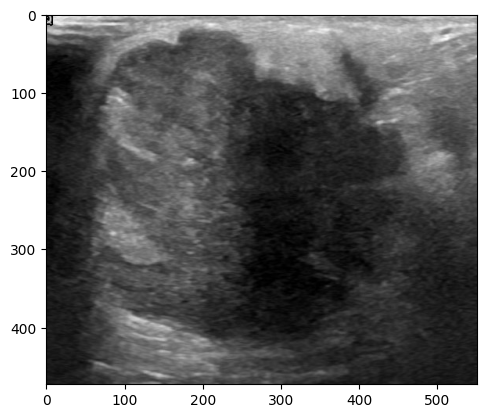

In [66]:
classImage('malignant (164).png')

### Função de Treinamento

In [100]:
def TrainingLoopNew(model, loader, lossFunc, optimizer):
    model.train()
    runningLoss = 0.

    for i, data in enumerate(loader):
        # Pixels e a marcação do dado.
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model.forward(inputs)
        loss = lossFunc(outputs, labels.float().view(*outputs.shape))

        # Zera os gradientes.
        optimizer.zero_grad()
        # Computa os gradientes.
        loss.backward()
        # Anda na direção que reduz o erro local.
        optimizer.step()

        runningLoss += loss.item()

        return runningLoss / len(loader)

    #     print('Epoca: {:3d} Loop: {:3d} de {:3d}, perda {:03.2f} de precisão {:03.2f}'.format(epoch+1, i+1, len(loader), loss, accuracy))
    
    # print('FIM: Epoca: {:3d}, perda {:.5f} de precisão {:.5f}'.format(epoch+1, runningLoss/len(loader), runningAccuracy/len(loader) ))

In [24]:
from PIL import Image
classNames  = ['normal', 'tumor']
def classImage(imgName):
    pathDir = r'C:\Users\terce\Documents\IC - Ultrasom\code\para testar'
    testImage = Image.open(pathDir + '/' + imgName)
    plt.imshow(testImage)
    testImage = testImage.resize((64,64))
    testImage = np.array(testImage.getdata()).reshape(*testImage.size, 3)
    testImage = testImage / 255
    testImage = testImage.transpose(2, 0, 1)
    testImage = torch.tensor(testImage, dtype=torch.float).view(-1, *testImage.shape)

    classificador.eval()

    testImage = testImage.to(device)
    testOutput = classificador.forward(testImage)
    if testOutput > 0.5:
        output = 1
    else:
        output = 0

    print('Prevision:', output)
    idx_to_class = {value: key for key, value in testDataset.class_to_idx.items()}

    return idx_to_class[output]

### Função de Validação

In [101]:
def ValidateLoopNew(model, loader, lossFunc):
    model.eval()
    runningLoss = 0.

    with torch.no_grad():
        for i, data in enumerate(loader):
            # Pixels e a marcação do dado
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model.forward(inputs)
            loss = lossFunc(outputs, labels.float().view(*outputs.shape))

            runningLoss += loss.item()

            return runningLoss / len(loader)

In [102]:
def plotLossesGraph(losses):
    fig = plt.figure(figsize=(13,5))
    ax = fig.gca()
    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)
    ax. legend (fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16" )
    ax.set_ylabel("Loss", fontsize="16" )
    ax.set_title("Loss vs iterations", fontsize="16")


In [103]:
epoch = 30
trainLoss = []
testLoss = []
for i in range(epoch):
    trloss = TrainingLoopNew(model, trainLoader, criterion, optimizer)
    trainLoss.append(trloss)
    if i % 10 == 0:
        print(f'{i*10} epochs')
    tsloss = ValidateLoopNew(model, testLoader, criterion)
    testLoss.append(tsloss)

0 epochs
100 epochs
200 epochs


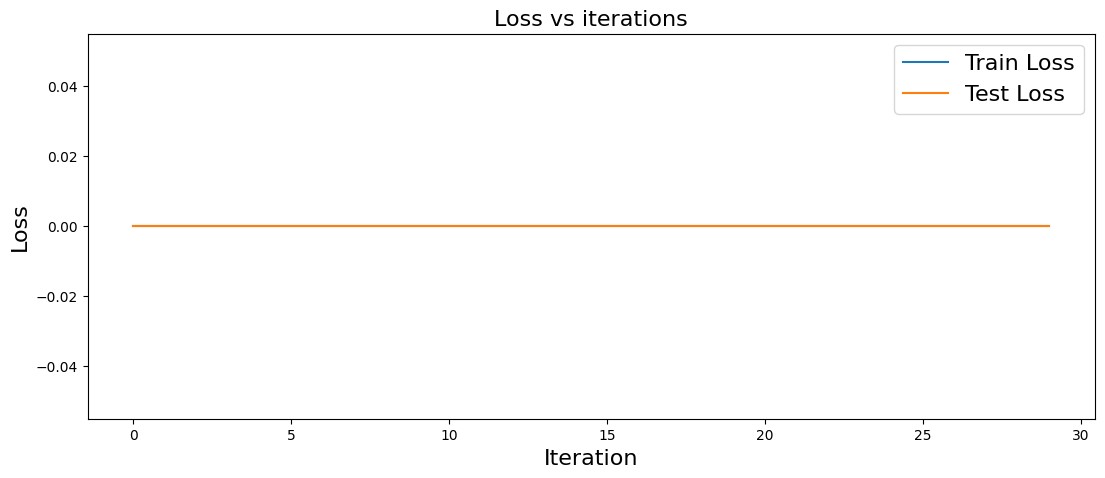

In [104]:
losses = {'Train Loss': trainLoss, 'Test Loss': testLoss}
plotLossesGraph(losses)

### Salvar Modelo

In [17]:
torch.save(model.state_dict(), r'C:\Users\terce\Documents\IC - Ultrasom\code\models\cnnmodel2.pth')